In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.svm import SVC

In [119]:
suicide = pd.read_csv('./Suicide_Detection.csv')

In [120]:
suicide.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [121]:
suicide[['class']].value_counts()

class      
non-suicide    116037
suicide        116037
Name: count, dtype: int64

In [122]:
suicide['class'] = np.where(suicide['class']=='suicide',1,0)#converting label to numeric

In [123]:
suicide.shape

(232074, 3)

In [124]:
suicide.isna().sum()

Unnamed: 0    0
text          0
class         0
dtype: int64

In [125]:
suicide['Unnamed: 0'].duplicated().sum()


np.int64(0)

In [126]:
suicide_drop_index = suicide.drop('Unnamed: 0',axis=1)

In [127]:
sample_suicide_drop_index = suicide_drop_index.iloc[:1000]

In [128]:
# Labels
y = sample_suicide_drop_index['class']

In [129]:
X = sample_suicide_drop_index.drop('class',axis=1)

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2,random_state=42)

In [131]:
#Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english',max_df=.7)
#Transform the text data to vectors
X_train_vectorized = vectorizer.fit_transform(X_train['text'])


Start with SVM

In [132]:
clf = SVC(kernel='linear')

In [133]:
clf.fit(X_train_vectorized,y_train)

SVC(kernel='linear')

In [134]:
print(cross_val_score(clf,X_train_vectorized,y_train,cv=3))

[0.88764045 0.88389513 0.89473684]


In [135]:
y_pred = cross_val_predict(clf,X_train_vectorized,y_train,cv=3,method='decision_function')

In [136]:
fpr,tpr,thresholds = roc_curve(y_train,y_pred)

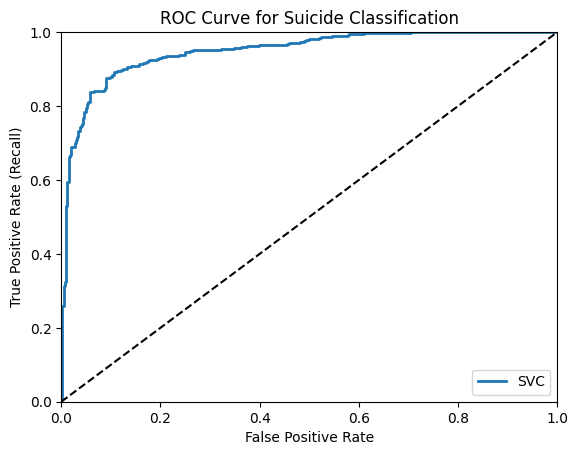

In [137]:
roc_auc_score(y_train,y_pred)
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('ROC Curve for Suicide Classification')
    plt.legend(loc='lower right')

plot_roc_curve(fpr,tpr,label='SVC')

plt.show()


In [138]:
roc_auc_score(y_train,y_pred)

np.float64(0.9486607142857144)

Random Forest

In [139]:
from sklearn.ensemble import RandomForestClassifier

In [140]:
forest_clf = RandomForestClassifier(random_state=42)

In [141]:
y_probas_forest = cross_val_predict(forest_clf,X_train_vectorized,y_train,cv=3,method="predict_proba")

In [142]:
y_scores_forest = y_probas_forest[:,1]

In [143]:
fpr_forest,tpr_forest,thresholds_forest = roc_curve(y_train,y_pred)

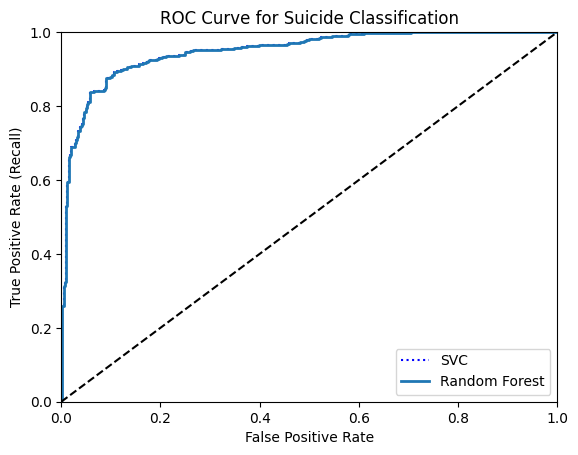

In [144]:
plt.plot(fpr,tpr,'b:',label='SVC')
plot_roc_curve(fpr_forest,tpr_forest,"Random Forest")
plt.show()

In [145]:
roc_auc_score(y_train,y_scores_forest)

np.float64(0.9264987244897959)

In [146]:
#from sklearn.linear_model import SGDClassifier


Fine-tuning

Error analysis

In [147]:
from sklearn.metrics import confusion_matrix

In [148]:
y_train_pred = cross_val_predict(clf,X_train_vectorized,y_train,cv=3)


In [149]:
conf_mx = confusion_matrix(y_train,y_train_pred)

In [150]:
conf_mx

array([[382,  26],
       [ 63, 329]])

In [152]:
y_train

array([0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,

In [153]:
X_tp = X_train[(y_train == 1) & (y_train_pred == 1)]
X_fn = X_train[(y_train == 1) & (y_train_pred == 0)]
X_fp = X_train[(y_train == 0) & (y_train_pred == 1)]
X_tn = X_train[(y_train == 0) & (y_train_pred == 0)]

In [155]:
pd.set_option('display.max_colwidth', None) 

In [160]:
X_fp.head()

,text
557,"I can’t find any good friends that will help me in life One of my friends just now was continuously roasting me about how ugly I am and how I cannot get girl, and ny friends just laughed and said “Ooohhhhhh” like I don’t know what to do man. I want to kill myself because I’m ugly"
587,"My life is so boring. It's gotten to the point that I find other people's lives more entertaining and interesting than my own, I have no friends, no funny or cool stories, no reason for anyone like like me in any way. So why should I even try to enjoy my own life"
468,Can we stop putting politics in kids shows? I just wanna see Bugs Bunny smash Elmer Fudd with a mallot is that too much to ask?\n\nI don't want to see OK KO talk about gun control.\n\nI don't want to see Gumball mock Trump.\n\nI just want to see Classic Slapstick between Sylvester and Tweety.\n\nI just want to see Wile E Coyote get crushed by a boulder.\n\nI don't want to see cartoons being a way to get the writers political views out to millions.\n\nI just want entertainment.
935,What's the worst advice you've gotten from reddit? Or real life or somewhere else but basically just the worst advice you've gotten in general.
148,"I feel like crying. I don't know where to post this so, I'm posting this here.\n\nI just feel like crying, for no reason. I was just minding my business when, my mom asked me something (that doesn't really matter to me anyway) and, I just... felt like it. I managed to go to my room without anyone noticing and... I'm just seating here now. Trying to get this out of me.\n\n(Sorry if I did any grammatical mistakes)"


In [159]:
X_fn.head()

,text
695,wtfI called the suicide hotline and it connected me to some veteran service and I was so embarrassed the dude didn’t even know how to help me I might actually kill myself
664,adopt mepls
994,"I just attempted and he doesn’t careI told my boyfriend I was going to hang myself, he said he couldn’t live with it I said I don’t think anyone can stop me, I said goodbye and he said goodbye, didn’t try to stop me at all I guess part of me was hoping he’d convince me to stop, I cried then went over to the noose tried to hang myself but couldn’t do it, almost had a panic attack. Nobody ever cares, or ever will. I knew the relationship was to good to be true."
3,i need helpjust help me im crying so hard
77,"Brain so damaged from drugs i don't feel human anymoreThat's pretty much all of i can say, my brain is full of shit and it is so fucking loud i can never have peace. \n\n- I written wall of text here but then i deleted it..."


In [158]:
X_tn.head()

,text
29,Nice songs &lt;3 Nice songs to vibe to-\nLoverboy/a-wall\nCome true/khai dreams\nWeak when ur around/blackbear \nAll I need/khai dreams\nCarwash/striptease (slowed)\nPlease listen to them :)
535,Does anyone play among us anymore? I've been trying to play but randos are no fun and my friends are assholes. Does anyone have a discord server or something where yall play among us?
165,I want to make out with Leela in the Planet Express office supply closet What’s Fry going to do about it?
918,"WHAT THE FUCK WHAT THE FUCK WHAT THE FUCK So i got a message request with a group, i meant to hit decline, and it accepted me. I immediatly left, but the most recent thing was a panty shot. What the fuck."
65,"So after being single for 16 years, I finally found one. She’s perfect. She’s charming. She’s the best I could find. She’s also super adorable.\n\nKylie, I know you’re gonna see this so I want you to know that I love you.\n\n u/iamatexan124"


In [157]:
X_tp.head()

text
836                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

Final

In [73]:
final_model = clf

In [76]:
final_prediction = final_model.predict(X_test)

In [77]:
roc_auc_score(y_test,final_prediction)

np.float64(0.8999899989999)